In [1]:
%load_ext autoreload
%autoreload 2

# Training Utilities

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
# from torch.optim import Adam, LBFGS, Optimizer
from torch.optim import Optimizer
from torch.optim import Adam
from src.opts.polyak_lbfgs import PolyakLBFGS
from src.opts.polyak_gd import PolyakGD
from src.opts.alr_mag import ALRMAG
from src.opts.sketchygn import SketchyGN
from src.opts.sketchysgd import SketchySGD
import random
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

'''
Implementation of PINNs. 

Source: https://github.com/AdityaLab/pinnsformer/blob/main/model/pinn.py
'''
class PINN(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
    super(PINN, self).__init__()

    layers = []
    for i in range(num_layer-1):
      if i == 0:
        layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
        layers.append(nn.Tanh())
      else:
        layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
        layers.append(nn.Tanh())

    layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

    self.linear = nn.Sequential(*layers)

  def forward(self, x, t):
    src = torch.cat((x,t), dim=-1)
    return self.linear(src)

class Adam_LBFGS(Optimizer):
    def __init__(self, params, switch_epoch, adam_params, lbfgs_params):
        # defaults = dict(switch_epoch=switch_epoch, adam_params=adam_params, lbfgs_params=lbfgs_params)

        self.switch_epoch = switch_epoch
        self.params = list(params)
        self.adam = Adam(self.params, **adam_params)
        self.lbfgs = PolyakLBFGS(self.params, **lbfgs_params)
        print(lbfgs_params)
        self.lbfgs_params = lbfgs_params

        super(Adam_LBFGS, self).__init__(self.params, defaults={})

        self.state['epoch'] = 0

    def step(self, closure=None):
        if self.state['epoch'] < self.switch_epoch:
            self.adam.step(closure)
        else:
            if self.state['epoch'] == self.switch_epoch:
                print(f'Switching to LBFGS optimizer at epoch {self.state["epoch"]}')
                # opt = LBFGS(self.adam.param_groups[0]["params"], **self.lbfgs_params)
                # assert opt.state_dict() == self.lbfgs.state_dict()
            self.lbfgs.step(closure)

        self.state['epoch'] += 1

class Adam_PolyakGD(Optimizer):
    def __init__(self, params, switch_epoch, adam_params):
        self.switch_epoch = switch_epoch
        self.params = list(params)
        self.adam = Adam(self.params, **adam_params)
        self.polyakgd = PolyakGD(self.params)

        super(Adam_PolyakGD, self).__init__(self.params, defaults={})

        self.state['epoch'] = 0

    def step(self, closure=None):
        if self.state['epoch'] < self.switch_epoch:
            self.adam.step(closure)
        else:
            if self.state['epoch'] == self.switch_epoch:
                print(
                    f'Switching to PolyakGD optimizer at epoch {self.state["epoch"]}')
            self.polyakgd.step(closure)

        self.state['epoch'] += 1

class Adam_ALRMAG(Optimizer):
    def __init__(self, params, switch_epoch, adam_params, alrmag_params):
        self.switch_epoch = switch_epoch
        self.params = list(params)
        self.adam = Adam(self.params, **adam_params)
        self.alrmag = ALRMAG(self.params, **alrmag_params)

        super(Adam_ALRMAG, self).__init__(self.params, defaults={})

        self.state['epoch'] = 0

    def step(self, closure=None):
        if self.state['epoch'] < self.switch_epoch:
            self.adam.step(closure)
        else:
            if self.state['epoch'] == self.switch_epoch:
                print(
                    f'Switching to ALRMAG optimizer at epoch {self.state["epoch"]}')
            self.alrmag.step(closure)

        self.state['epoch'] += 1

"""
Helper function for obtaining corresponding domain and loss function of the chosen PDE type. 

INPUT: 
- pde_name: string; name of the PDE problem
- pde_params_list: list of strings; coefficients of the PDE
- loss_name: string; name of the loss type
OUTPUT: 
- x_range: list of size 2; lower and upper bounds of spatial variable x
- t_range: list of size 2; lower and upper bounds of temporal variable t
- loss_func: loss function that takes (x,t,pred) and computes the total loss
- pde_coefs: dictionary containing coefficients of the PDE
"""
def get_pde(pde_name, pde_params_list, loss_name): 
    # determine loss type
    loss_options = {
        "l1": {"res": nn.L1Loss(), "bc": nn.L1Loss(), "ic": nn.L1Loss()},
        "mse": {"res": nn.MSELoss(), "bc": nn.MSELoss(), "ic": nn.MSELoss()},
        "huber": {"res": nn.HuberLoss(), "bc": nn.HuberLoss(), "ic": nn.HuberLoss()},
        "hybrid": {"res": nn.HuberLoss(), "bc": nn.MSELoss(), "ic": nn.MSELoss()}
    }
    try: 
        loss_type = loss_options[loss_name]
    except KeyError as ke:
        raise RuntimeError("{} is not a valid loss type.".format(ke))

    # parse PDE parameters
    pde_coefs = parse_params_list(pde_params_list)
    
    # determine pde type
    if pde_name == "convection": 
        if "beta" not in pde_coefs.keys(): 
            raise KeyError("beta is not specified for convection PDE.")

        x_range = [0, 2 * np.pi]
        t_range = [0, 1]

        def loss_func(x, t, pred): 
            x_res, x_left, x_upper, x_lower = x
            t_res, t_left, t_upper, t_lower = t
            outputs_res, outputs_left, outputs_upper, outputs_lower = pred

            u_x = torch.autograd.grad(outputs_res, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

            loss_res = loss_type["res"](u_t + pde_coefs["beta"] * u_x, torch.zeros_like(u_t))
            loss_bc = loss_type["bc"](outputs_upper - outputs_lower, torch.zeros_like(outputs_upper))
            loss_ic = loss_type["ic"](outputs_left[:,0], torch.sin(x_left[:,0]))

            # loss = loss_res + loss_bc + loss_ic

            return loss_res, loss_bc, loss_ic

    elif pde_name == "reaction_diffusion": 
        if not {"nu", "rho"} <= pde_coefs.keys(): 
            raise KeyError("nu or rho is not specified for reaction diffusion PDE.")

        x_range = [0, 2 * np.pi]
        t_range = [0, 1]

        def loss_func(x, t, pred): 
            x_res, x_left, x_upper, x_lower = x
            t_res, t_left, t_upper, t_lower = t
            outputs_res, outputs_left, outputs_upper, outputs_lower = pred

            u_x = torch.autograd.grad(outputs_res, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

            loss_res = loss_type["res"](u_t - pde_coefs["nu"] * u_xx - pde_coefs["rho"] * outputs_res * (1 - outputs_res), torch.zeros_like(u_t))
            loss_bc = loss_type["bc"](outputs_upper - outputs_lower, torch.zeros_like(outputs_upper))
            loss_ic = loss_type["ic"](outputs_left[:,0], torch.exp(-(1/2) * torch.square((x_left[:,0] - np.pi) / (np.pi / 4))))

            # loss = loss_res + loss_bc + loss_ic

            return loss_res, loss_bc, loss_ic

    elif pde_name == "reaction": 
        if "rho" not in pde_coefs.keys(): 
            raise KeyError("rho is not specified for reaction PDE.")

        x_range = [0, 2 * np.pi]
        t_range = [0, 1]

        def loss_func(x, t, pred): 
            x_res, x_left, x_upper, x_lower = x
            t_res, t_left, t_upper, t_lower = t
            outputs_res, outputs_left, outputs_upper, outputs_lower = pred

            u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

            loss_res = loss_type["res"](u_t - pde_coefs["rho"] * outputs_res * (1 - outputs_res), torch.zeros_like(u_t))
            loss_bc = loss_type["bc"](outputs_upper - outputs_lower, torch.zeros_like(outputs_upper))
            loss_ic = loss_type["ic"](outputs_left[:,0], torch.exp(-(1/2) * torch.square((x_left[:,0] - np.pi) / (np.pi / 4))))

            # loss = loss_res + loss_bc + loss_ic

            return loss_res, loss_bc, loss_ic

    elif pde_name == "wave":
        if "beta" not in pde_coefs.keys():
            raise KeyError("beta is not specified for wave PDE.")

        x_range = [0, 1]
        t_range = [0, 1]

        def loss_func(x, t, pred):
            x_res, x_left, x_upper, x_lower = x
            t_res, t_left, t_upper, t_lower = t
            outputs_res, outputs_left, outputs_upper, outputs_lower = pred

            u_x = torch.autograd.grad(outputs_res, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

            loss_res = loss_type["res"](u_tt - 4 * u_xx, torch.zeros_like(u_tt))
            loss_bc = loss_type["bc"](outputs_upper, torch.zeros_like(outputs_upper)) + loss_type["bc"](outputs_lower, torch.zeros_like(outputs_lower))

            ui_t = torch.autograd.grad(outputs_left, t_left, grad_outputs=torch.ones_like(outputs_left), retain_graph=True, create_graph=True)[0]

            loss_ic_1 = loss_type["ic"](outputs_left[:,0], torch.sin(np.pi * x_left[:,0]) + 0.5 * torch.sin(pde_coefs["beta"] * np.pi * x_left[:,0]))
            loss_ic_2 = loss_type["ic"](ui_t, torch.zeros_like(ui_t))

            loss_ic = loss_ic_1 + loss_ic_2

            return loss_res, loss_bc, loss_ic

    else: 
        raise RuntimeError("{} is not a valid PDE name.".format(pde_name))

    return x_range, t_range, loss_func, pde_coefs

"""
Helper function for computing reference solution to the given PDE at given points. 

INPUT: 
- pde_name: string; name of the PDE problem
- pde_coefs: dictionary containing coefficients of the PDE
- x: tuple of (x_res, x_left, x_upper, x_lower)
- t: tuple of (t_res, t_left, t_upper, t_lower)
- data_params: dictionary containing parameters used to generate the data
OUTPUT: 
- sol: 
"""
def get_ref_solutions(pde_name, pde_coefs, x, t, data_params): 
    if pde_name == "convection": 
        sol = np.vstack([np.sin(x[i].cpu().detach().numpy() - pde_coefs["beta"] * t[i].cpu().detach().numpy()) for i in range(len(x))])
    
    elif pde_name == "reaction_diffusion": 
        # unpack data-generation parameters
        x_range = data_params["x_range"]
        t_range = data_params["t_range"]
        x_num = data_params["x_num"]
        t_num = data_params["t_num"]
        res_idx = data_params["res_idx"]
        # generate grid
        x = np.linspace(x_range[0], x_range[1], x_num-1, endpoint=False).reshape(-1, 1) # exclude upper boundary
        t = np.linspace(t_range[0], t_range[1], t_num).reshape(-1, 1)
        x_mesh, t_mesh = np.meshgrid(x, t)
        # compute initial solution
        u0 = np.exp(-(1/2) * np.square((x - np.pi) / (np.pi / 4))).flatten()
        u = np.zeros((x_num, t_num))
        u[:-1,0] = u0

        IKX_pos = 1j * np.arange(0, (x_num-1) / 2 + 1, 1)
        IKX_neg = 1j * np.arange(-(x_num-1) / 2 + 1, 0, 1)
        IKX = np.concatenate((IKX_pos, IKX_neg))
        IKX2 = IKX * IKX
        # perform time-marching
        t_step_size = (t_range[1] - t_range[0]) / (t_num - 1)
        u_t = u0.copy()
        for i in range(t_num - 1): 
            # reaction component
            factor = u_t * np.exp(pde_coefs['rho'] * t_step_size)
            u_t = factor / (factor + (1 - u_t))
            # diffusion component
            factor = np.exp(pde_coefs['nu'] * IKX2 * t_step_size)
            u_hat = np.fft.fft(u_t) * factor
            u_t = np.real(np.fft.ifft(u_hat))
            u[:-1,i+1] = u_t

        # add back solution on the upper boundary using the periodic boundary condition
        u[-1,:] = u[0,:]
        # split the solution
        sol_left = u[:,0].reshape(-1,1)
        sol_upper = u[-1,:].reshape(-1,1)
        sol_lower = u[0,:].reshape(-1,1)
        sol_res = u[1:-1, 1:].T.reshape(-1,1)[res_idx]

        sol = np.vstack([sol_res, sol_left, sol_upper, sol_lower])
    
    elif pde_name == "reaction": 
        def compute_sol(x, t): 
            initial_func_term = np.exp(-(1/2) * np.square((x - np.pi) / (np.pi / 4)))
            exp_term = np.exp(pde_coefs['rho'] * t)
            return initial_func_term * exp_term / (initial_func_term * exp_term + 1 - initial_func_term)
        
        sol = np.vstack([compute_sol(x[i].cpu().detach().numpy(), t[i].cpu().detach().numpy()) for i in range(len(x))])

    elif pde_name == "wave":
        def compute_sol(x, t):
            return np.sin(np.pi * x) * np.cos(2 * np.pi * t) \
                + 0.5 * np.sin(pde_coefs["beta"] * np.pi * x) * np.cos(2 * pde_coefs["beta"] * np.pi * t)

        sol = np.vstack([compute_sol(x[i].cpu().detach().numpy(), t[i].cpu().detach().numpy()) for i in range(len(x))])

    else: 
        raise RuntimeError("{} is not a valid PDE name.".format(pde_name))
    
    return sol

"""
Helper function for setting seed for the random number generator in various packages.

INPUT: 
- seed: integer
"""
def set_random_seed(seed): 
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

"""
Helper function for generating data on a grid. 

INPUT: 
- x_range: list of size 2; lower and upper bounds of spatial variable x
- t_range: list of size 2; lower and upper bounds of temporal variable t
- x_num: positive integer; number of x points
- t_num: positive integer; number of t points
- random: boolean; indication whether to (uniformly) randomly from the grid
- num_res_samples: positive integer; number of random samples to draw for residual points
- device: string; the device that the samples will be stored at
OUTPUT: 
- x: tuple of (x_res, x_left, x_upper, x_lower)
- t: tuple of (t_res, t_left, t_upper, t_lower)
- data_params: dictionary containing parameters used to generate the data 
               including x_range, t_range, x_num, t_num, grid_multiplier, and res_idx
where: 
> res: numpy array / tensor of size (x_num-2)(t_num-1) * 2 or num_res_samples * 2; residual points (interior grid or random samples from it)
> b_left: numpy array / tensor of size (x_num) * 2; initial points (corresponding to initial time step)
> b_upper: numpy array / tensor of size (t_num) * 2; upper boundary points
> b_lower: numpy array / tensor of size (t_num) * 2; lower boundary points
> res_idx: numpy array of length (x_num-2)(t_num-1) or num_res_samples; corresponding indices of the sampled residual points from the interior grid
"""
def get_data(x_range, t_range, x_num, t_num, random=False, num_res_samples=1e4, device='cpu'):
    # generate initial and boundary points
    x = np.linspace(x_range[0], x_range[1], x_num).reshape(-1, 1)
    t = np.linspace(t_range[0], t_range[1], t_num).reshape(-1, 1)
    # initial time
    x_left = x.copy()
    t_left = t_range[0] * np.ones([x_num,1])
    # lower boundary
    x_lower = x_range[0] * np.ones([t_num,1])
    t_lower = t.copy()
    # upper boundary
    x_upper = x_range[1] * np.ones([t_num,1])
    t_upper = t.copy()
    # residual points
    x_mesh, t_mesh = np.meshgrid(x[1:-1], t[1:])
    data_params = {
        "x_range": x_range, 
        "t_range": t_range, 
        "x_num": x_num, 
        "t_num": t_num
    }
    if random: 
        mesh = np.hstack((x_mesh.flatten()[:, None], t_mesh.flatten()[:, None]))
        idx = np.random.choice(mesh.shape[0], num_res_samples, replace=False)
        x_res = mesh[idx, 0:1]
        t_res = mesh[idx, 1:2]
        data_params["res_idx"] = idx
    else: 
        x_res = x_mesh.reshape(-1,1)
        t_res = t_mesh.reshape(-1,1)
        data_params["res_idx"] = np.arange((x_num - 2) * (t_num - 1))

    # move data to target device
    if device != 'cpu': 
        x_left = torch.tensor(x_left, dtype=torch.float32, requires_grad=True).to(device)
        t_left = torch.tensor(t_left, dtype=torch.float32, requires_grad=True).to(device)
        x_upper = torch.tensor(x_upper, dtype=torch.float32, requires_grad=True).to(device)
        t_upper = torch.tensor(t_upper, dtype=torch.float32, requires_grad=True).to(device)
        x_lower = torch.tensor(x_lower, dtype=torch.float32, requires_grad=True).to(device)
        t_lower = torch.tensor(t_lower, dtype=torch.float32, requires_grad=True).to(device)
        x_res = torch.tensor(x_res, dtype=torch.float32, requires_grad=True).to(device)
        t_res = torch.tensor(t_res, dtype=torch.float32, requires_grad=True).to(device)

    # form tuples
    x = (x_res, x_left, x_upper, x_lower)
    t = (t_res, t_left, t_upper, t_lower)

    return x, t, data_params

"""
Helper function for initializing neural net parameters. 
"""
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

"""
Helper function for making predictions with PINN. 

INPUT: 
- x: tutple of (x_res, x_left, x_upper, x_lower)
- t: tutple of (t_res, t_left, t_upper, t_lower)
- model: PINN model
OUTPUT: 
- preds: tuple of (pred_res, pred_left, pred_upper, pred_lower)
where: 
> pred_res: predictions on residual points
> pred_left: predictions on initial points
> pred_upper: predictions on upper boundary points
> pred_lower: predictions on lower boundary points
"""
def predict(x, t, model): 
    x_res, x_left, x_upper, x_lower = x
    t_res, t_left, t_upper, t_lower = t
    
    pred_res = model(x_res, t_res)
    pred_left = model(x_left, t_left)
    pred_upper = model(x_upper, t_upper)
    pred_lower = model(x_lower, t_lower)
    
    preds = (pred_res, pred_left, pred_upper, pred_lower) 
    
    return preds

"""
Helper function for computing l1 relative error. 

INPUT: 
- prediction: numpy array of predictions from the model
- target: numpy array of ground truths
OUTPUT: 
- error: scalar; computed relative error
"""
def l1_relative_error(prediction, target): 
    return np.sum(np.abs(target-prediction)) / np.sum(np.abs(target))

"""
Helper function for computing l2 relative error. 

INPUT: 
- prediction: numpy array of predictions from the model
- target: numpy array of ground truths
OUTPUT: 
- error: scalar; computed relative error
"""
def l2_relative_error(prediction, target): 
    return np.sqrt(np.sum((target-prediction)**2) / np.sum(target**2))

"""
Helper function for initializing the optimizer with specified parameters. 

INPUT: 
- opt_name: string; name of the optimizer
- opt_params: dictionary; arguments used to initialize the optimizer
- model_params: dictionary; contains Tensors of the model to be optimized
OUTPUT: 
- opt: torch.optim.Optimizer instance
"""
def get_opt(opt_name, opt_params, model_params):
    if opt_name == 'adam':
        return Adam(model_params, **opt_params)
    elif opt_name == 'lbfgs':
        if "history_size" in opt_params:
            opt_params["history_size"] = int(opt_params["history_size"])
        return LBFGS(model_params, **opt_params, line_search_fn='strong_wolfe')
    elif opt_name == 'polyak_gd':
        return PolyakGD(model_params, **opt_params)
    elif opt_name == 'alr_mag':
        return ALRMAG(model_params, **opt_params)
    elif opt_name == 'adam_lbfgs':
        if "switch_epoch" not in opt_params:
            raise KeyError("switch_epoch is not specified for Adam_LBFGS optimizer.")
        switch_epoch = opt_params["switch_epoch"]

        # Get parameters for Adam and LBFGS, remove the prefix "adam_" and "lbfgs_" from the keys
        adam_params = {k[5:]: v for k, v in opt_params.items() if k.startswith("adam_")}
        lbfgs_params = {k[6:]: v for k, v in opt_params.items() if k.startswith("lbfgs_")}
        lbfgs_params["line_search_fn"] = "strong_wolfe_pp"
        
        # If max_iter or history_size is specified, convert them to integers
        if "max_iter" in lbfgs_params:
            lbfgs_params["max_iter"] = int(lbfgs_params["max_iter"])
        if "history_size" in lbfgs_params:
            lbfgs_params["history_size"] = int(lbfgs_params["history_size"])

        return Adam_LBFGS(model_params, switch_epoch, adam_params, lbfgs_params)
    elif opt_name == 'adam_polyakgd':
        if "switch_epoch" not in opt_params:
            raise KeyError("switch_epoch is not specified for Adam_PolyakGD optimizer.")
        switch_epoch = opt_params["switch_epoch"]

        # Get parameters for Adam, remove the prefix "adam_" from the keys
        adam_params = {k[5:]: v for k, v in opt_params.items() if k.startswith("adam_")}
        
        return Adam_PolyakGD(model_params, switch_epoch, adam_params)
    elif opt_name == 'adam_alrmag':
        if "switch_epoch" not in opt_params:
            raise KeyError("switch_epoch is not specified for Adam_ALRMAG optimizer.")
        switch_epoch = opt_params["switch_epoch"]

        # Get parameters for Adam, remove the prefix "adam_" from the keys
        adam_params = {k[5:]: v for k, v in opt_params.items() if k.startswith("adam_")}
        alrmag_params = {k[7:]: v for k, v in opt_params.items() if k.startswith("alrmag_")}
        
        return Adam_ALRMAG(model_params, switch_epoch, adam_params, alrmag_params)
    else:
        raise ValueError(f'Optimizer {opt_name} not supported')

"""
Helper function for parsing a mixed list of strings and numerical values. 

INPUT: 
- params_list: list of strings
OUTPUT: 
- params_dict: dictionary
"""
def parse_params_list(params_list): 
    # return an empty dictionary if there is no parameters specified
    if params_list is None: 
        return {}

    # parse parameter names and specified (if any) values
    params_dict = {}
    current_parameter = None
    match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
    for token in params_list: 
        # attempt to extract a number from the token
        parsed_number = re.search(match_number, token)
        # if no match is found, then the token is a parameter name
        if parsed_number is None:
            params_dict[token] = None
            current_parameter = token
        # if the token indeed is a number (integer, decimal, or in scientific notation)
        else: 
            # append to the list of values associated with current parameter
            params_dict[current_parameter] = float(parsed_number.group())
    
    return params_dict

"""
Helper function for forming optimizer parameters. 

INPUT: 
- opt_params_list: list of strings
OUTPUT: 
- opt_params: dictionary
"""
def get_opt_params(opt_params_list): 
    return parse_params_list(opt_params_list)

# Experiment

In [3]:
# initial_seed = 234
# pde_name = "convection"
# pde_params = ["beta", "40"]
# opt_name = "adam_alrmag"
# switch_epoch = 1000
# adam_lr = 0.001
# lbfgs_history_size = 100
# lbfgs_max_iter = 20
# alrmag_beta = 0.8
# # lbfgs_line_search_fn = "strong_wolfe_pp"
# opt_params_list = ["switch_epoch", str(switch_epoch), "adam_lr", str(adam_lr), 
#                     "alrmag_beta", str(alrmag_beta)] 
# # "lbfgs_history_size", str(lbfgs_history_size), "lbfgs_max_iter", str(lbfgs_max_iter)]
# num_layers = 4
# num_neurons = 200
# loss_name = "mse"
# num_x = 257
# num_t = 101
# num_res = 10000
# num_epochs = 10000
# device = "cuda:7"

# set_random_seed(initial_seed)

# model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)

# x_range, t_range, loss_func, pde_coefs = get_pde(pde_name, pde_params, loss_name)
# opt_params = get_opt_params(opt_params_list)
# opt = get_opt(opt_name, opt_params, model.parameters())
# x, t, data_params = get_data(x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

# loss_hist = []
# loss_res_hist = []
# loss_bc_hist = []
# loss_ic_hist = []
# grad_norm_hist = []

# loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
# loss = loss_res + loss_bc + loss_ic

# loss_hist.append(loss.item())
# loss_res_hist.append(loss_res.item())
# loss_bc_hist.append(loss_bc.item())
# loss_ic_hist.append(loss_ic.item())

# for i in (progress_bar:=tqdm(range(num_epochs), ncols=125)):
    
#     model.train()
#     def closure():
#         opt.zero_grad()
#         outputs = predict(x, t, model)
#         loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
#         loss = loss_res + loss_bc + loss_ic
#         loss.backward()

#         return loss
    
#     opt.step(closure)
    
#     model.eval()
#     loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
#     loss = loss_res + loss_bc + loss_ic
    
#     grad_norm = 0
#     for p in model.parameters():
#         grad_norm += p.grad.norm().item() ** 2
#     grad_norm = grad_norm ** 0.5
    
#     loss_hist.append(loss.item())
#     loss_res_hist.append(loss_res.item())
#     loss_bc_hist.append(loss_bc.item())
#     loss_ic_hist.append(loss_ic.item())
#     grad_norm_hist.append(grad_norm)
    
#     progress_bar.set_postfix_str("res {:.2e} / bc {:.2e} / ic {:.2e} / grad_norm {:.2e}".format(loss_res_hist[-1], loss_bc_hist[-1], loss_ic_hist[-1], grad_norm))

### Adam + SketchyGN Combo

### Note: this may not be correct yet for the wave pde because it has two initial conditions that are added together

In [4]:
# initial_seed = 234
# pde_name = "convection"
# pde_params = ["beta", "40"]
# adam_lr = 0.001
# switch_epoch = 1000
# num_layers = 4
# num_neurons = 200
# loss_name = "mse"
# num_x = 257
# num_t = 101
# num_res = 10000
# num_epochs = 10000
# device = "cuda:7"

# precond_update_freq = 20
# sketch_warmup = 100

# set_random_seed(initial_seed)

# model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)

# x_range, t_range, loss_func, pde_coefs = get_pde(pde_name, pde_params, loss_name)
# x, t, data_params = get_data(x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

# loss_hist = []
# loss_res_hist = []
# loss_bc_hist = []
# loss_ic_hist = []
# grad_norm_hist = []

# loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
# loss = loss_res + loss_bc + loss_ic

# loss_hist.append(loss.item())
# loss_res_hist.append(loss_res.item())
# loss_bc_hist.append(loss_bc.item())
# loss_ic_hist.append(loss_ic.item())

# opt = Adam(model.parameters(), lr=adam_lr)

# for i in (progress_bar:=tqdm(range(num_epochs), ncols=125)):

#     model.train()

#     if i == switch_epoch:
#         opt = SketchyGN(model.parameters(), lr=1e-3, beta=0.999, rank=30, line_search_fn="armijo")
#         # Warmup sketch
#         for j in range(sketch_warmup):
#             opt.zero_grad()
#             outputs = predict(x, t, model)
#             n_res = outputs[0].shape[0]
#             n_ic = outputs[1].shape[0]
#             n_bc = outputs[2].shape[0]
#             outputs_res = outputs[0] + torch.randn_like(outputs[0]) * (n_res ** 0.5) # Residual points
#             outputs_ic = outputs[1] + torch.randn_like(outputs[1]) * (n_ic ** 0.5) # Initial condition points
#             outputs_bc = outputs[2] + torch.randn_like(outputs[2]) * (n_bc ** 0.5) # Upper boundary points
#             # We do not need to add noise to lower boundary points because we want 
#             # to add noise to the difference between upper and lower boundary points
#             loss_res, loss_bc, loss_ic = loss_func(x, t, (outputs_res, outputs_ic, outputs_bc, outputs[3]))
#             grad_flat_list = []

#             opt.zero_grad()
#             loss_res.backward()
#             grads = [p.grad if p.grad is not None else torch.zeros_like(
#                 p) for p in model.parameters()]
#             grad_flat_list.append(parameters_to_vector(grads))

#             opt.zero_grad()
#             loss_bc.backward()
#             grads = [p.grad if p.grad is not None else torch.zeros_like(
#                 p) for p in model.parameters()]
#             grad_flat_list.append(parameters_to_vector(grads))

#             opt.zero_grad()
#             loss_ic.backward()
#             grads = [p.grad if p.grad is not None else torch.zeros_like(
#                 p) for p in model.parameters()]
#             grad_flat_list.append(parameters_to_vector(grads))

#             opt.update_sketch(grad_flat_list, bsz=1) # Only need bsz=1 because we scaled the noise appropriately
#         opt.update_preconditioner()

#     def closure():
#         opt.zero_grad()
#         outputs = predict(x, t, model)
#         loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
#         loss = loss_res + loss_bc + loss_ic
#         loss.backward()

#         return loss
            
#     opt.step(closure)

#     # Update sketch with an unbiased estimate of the GGN matrix
#     if i >= switch_epoch:
#         opt.zero_grad()
#         outputs = predict(x, t, model)
#         n_res = outputs[0].shape[0]
#         n_ic = outputs[1].shape[0]
#         n_bc = outputs[2].shape[0]
#         outputs_res = outputs[0] + torch.randn_like(outputs[0]) * (n_res ** 0.5) # Residual points
#         outputs_ic = outputs[1] + torch.randn_like(outputs[1]) * (n_ic ** 0.5) # Initial condition points
#         outputs_bc = outputs[2] + torch.randn_like(outputs[2]) * (n_bc ** 0.5) # Upper boundary points
#         # We do not need to add noise to lower boundary points because we want 
#         # to add noise to the difference between upper and lower boundary points
#         loss_res, loss_bc, loss_ic = loss_func(x, t, (outputs_res, outputs_ic, outputs_bc, outputs[3]))
#         grad_flat_list = []

#         opt.zero_grad()
#         loss_res.backward()
#         grads = [p.grad if p.grad is not None else torch.zeros_like(
#             p) for p in model.parameters()]
#         grad_flat_list.append(parameters_to_vector(grads))

#         opt.zero_grad()
#         loss_bc.backward()
#         grads = [p.grad if p.grad is not None else torch.zeros_like(
#             p) for p in model.parameters()]
#         grad_flat_list.append(parameters_to_vector(grads))

#         opt.zero_grad()
#         loss_ic.backward()
#         grads = [p.grad if p.grad is not None else torch.zeros_like(
#             p) for p in model.parameters()]
#         grad_flat_list.append(parameters_to_vector(grads))

#         opt.update_sketch(grad_flat_list, bsz=1) # Only need bsz=1 because we scaled the noise appropriately

#         # Update preconditioner
#         if (i + 1) % precond_update_freq == 0:
#             opt.update_preconditioner()

#         if (i + 1) % (precond_update_freq * 20) == 0:
#             print('S: ', opt.S)

#     model.eval()
#     loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
#     loss = loss_res + loss_bc + loss_ic

#     grad_norm = 0
#     for p in model.parameters():
#         grad_norm += p.grad.norm().item() ** 2
#     grad_norm = grad_norm ** 0.5

#     loss_hist.append(loss.item())
#     loss_res_hist.append(loss_res.item())
#     loss_bc_hist.append(loss_bc.item())
#     loss_ic_hist.append(loss_ic.item())
#     grad_norm_hist.append(grad_norm)

#     progress_bar.set_postfix_str("res {:.2e} / bc {:.2e} / ic {:.2e} / grad_norm {:.2e}".format(loss_res_hist[-1], loss_bc_hist[-1], loss_ic_hist[-1], grad_norm))

### Adam + SketchySGD Combo

In [5]:
initial_seed = 234
pde_name = "convection"
pde_params = ["beta", "40"]
adam_lr = 0.001
switch_epoch = 1000
num_layers = 4
num_neurons = 200
loss_name = "mse"
num_x = 257
num_t = 101
num_res = 10000
num_epochs = 10000
device = "cuda:7"

precond_update_freq = 20

set_random_seed(initial_seed)

model = PINN(in_dim=2, hidden_dim=num_neurons,
             out_dim=1, num_layer=num_layers).to(device)

x_range, t_range, loss_func, pde_coefs = get_pde(
    pde_name, pde_params, loss_name)
x, t, data_params = get_data(
    x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

loss_hist = []
loss_res_hist = []
loss_bc_hist = []
loss_ic_hist = []
grad_norm_hist = []
step_size_hist = []

loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
loss = loss_res + loss_bc + loss_ic

loss_hist.append(loss.item())
loss_res_hist.append(loss_res.item())
loss_bc_hist.append(loss_bc.item())
loss_ic_hist.append(loss_ic.item())

opt = Adam(model.parameters(), lr=adam_lr)

for i in (progress_bar := tqdm(range(num_epochs), ncols=125)):
    model.train()

    if i == switch_epoch:
        opt = SketchySGD(model.parameters(), lr=1e0, rank=200, rho=0.1, line_search_fn="armijo")

    if isinstance(opt, SketchySGD) and i % precond_update_freq == 0:
        opt.zero_grad()
        outputs = predict(x, t, model)
        loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
        loss = loss_res + loss_bc + loss_ic
        grad_tuple = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        opt.update_preconditioner(grad_tuple)
        if i % (10 * precond_update_freq) == 0:
            print('S: ', opt.S)

    def closure():
        opt.zero_grad()
        outputs = predict(x, t, model)
        loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
        loss = loss_res + loss_bc + loss_ic
        loss.backward()

        return loss
            
    opt.step(closure)

    model.eval()
    loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
    loss = loss_res + loss_bc + loss_ic

    grad_norm = 0
    for p in model.parameters():
        grad_norm += p.grad.norm().item() ** 2
    grad_norm = grad_norm ** 0.5

    loss_hist.append(loss.item())
    loss_res_hist.append(loss_res.item())
    loss_bc_hist.append(loss_bc.item())
    loss_ic_hist.append(loss_ic.item())
    grad_norm_hist.append(grad_norm)

    if isinstance(opt, SketchySGD):
        step_size_hist.append(opt.state_dict()['state'][0]['t'])

    progress_bar.set_postfix_str("res {:.2e} / bc {:.2e} / ic {:.2e} / grad_norm {:.2e}".format(loss_res_hist[-1], loss_bc_hist[-1], loss_ic_hist[-1], grad_norm))

 10%|██                   | 999/10000 [00:34<04:38, 32.30it/s, res 5.09e-03 / bc 5.59e-03 / ic 4.62e-01 / grad_norm 1.60e+00]

S:  tensor([1.4563e+03, 7.6444e+02, 3.1643e+02, 5.7034e+01, 3.2452e+01, 1.9694e+01,
        9.9253e+00, 5.8962e+00, 2.4263e+00, 2.1551e+00, 8.9014e-01, 8.2106e-01,
        6.8448e-01, 5.4751e-01, 4.8987e-01, 4.5296e-01, 4.2439e-01, 3.8851e-01,
        3.7753e-01, 3.5198e-01, 3.1572e-01, 3.0445e-01, 2.8425e-01, 2.7552e-01,
        2.6787e-01, 2.5726e-01, 2.3949e-01, 2.1829e-01, 2.1311e-01, 2.0502e-01,
        2.0179e-01, 1.9285e-01, 1.8261e-01, 1.7917e-01, 1.7673e-01, 1.7012e-01,
        1.6355e-01, 1.5974e-01, 1.5355e-01, 1.4866e-01, 1.4705e-01, 1.4327e-01,
        1.3599e-01, 1.3293e-01, 1.3178e-01, 1.2933e-01, 1.2687e-01, 1.2508e-01,
        1.2229e-01, 1.1886e-01, 1.1615e-01, 1.1366e-01, 1.0987e-01, 1.0851e-01,
        1.0565e-01, 1.0479e-01, 1.0378e-01, 1.0204e-01, 1.0059e-01, 9.9465e-02,
        9.7494e-02, 9.5880e-02, 9.4296e-02, 9.1374e-02, 8.9541e-02, 8.8515e-02,
        8.6674e-02, 8.5017e-02, 8.3608e-02, 8.3229e-02, 8.1726e-02, 8.0209e-02,
        7.9245e-02, 7.8116e-02, 7.71

 12%|██▏               | 1201/10000 [01:53<3:17:49,  1.35s/it, res 6.30e-03 / bc 6.55e-02 / ic 2.94e-01 / grad_norm 2.27e+00]

S:  tensor([1.7683e+05, 7.5800e+03, 1.3046e+03, 7.9114e+02, 2.6972e+02, 1.4610e+02,
        1.0250e+02, 5.1479e+01, 4.7472e+01, 2.1411e+01, 1.9827e+01, 1.5284e+01,
        1.3405e+01, 1.2077e+01, 1.0618e+01, 8.2363e+00, 8.0489e+00, 6.8533e+00,
        6.5918e+00, 6.2546e+00, 5.3749e+00, 5.1897e+00, 4.9989e+00, 4.5861e+00,
        4.5360e+00, 4.1915e+00, 3.9369e+00, 3.7962e+00, 3.6324e+00, 3.4254e+00,
        3.2322e+00, 3.2133e+00, 3.0988e+00, 2.9051e+00, 2.8564e+00, 2.7913e+00,
        2.6251e+00, 2.5796e+00, 2.3929e+00, 2.3580e+00, 2.2244e+00, 2.1454e+00,
        2.1119e+00, 2.0663e+00, 1.9727e+00, 1.9380e+00, 1.8806e+00, 1.8214e+00,
        1.7888e+00, 1.7332e+00, 1.7079e+00, 1.6611e+00, 1.6271e+00, 1.5921e+00,
        1.5671e+00, 1.5368e+00, 1.5055e+00, 1.4900e+00, 1.4704e+00, 1.4089e+00,
        1.3930e+00, 1.3650e+00, 1.3482e+00, 1.3285e+00, 1.3007e+00, 1.2826e+00,
        1.2614e+00, 1.2271e+00, 1.2215e+00, 1.1862e+00, 1.1586e+00, 1.1339e+00,
        1.1310e+00, 1.1086e+00, 1.08

 14%|██▌               | 1401/10000 [03:11<3:23:53,  1.42s/it, res 4.23e-03 / bc 6.62e-02 / ic 5.38e-02 / grad_norm 3.65e+00]

S:  tensor([1.3012e+05, 2.7135e+03, 2.1816e+03, 3.5424e+02, 2.6646e+02, 1.8311e+02,
        8.5397e+01, 6.0598e+01, 4.6703e+01, 2.7233e+01, 2.5915e+01, 2.4207e+01,
        1.7690e+01, 1.2060e+01, 1.0310e+01, 9.5893e+00, 8.4621e+00, 7.5755e+00,
        6.7898e+00, 6.3199e+00, 5.6081e+00, 5.0286e+00, 4.6993e+00, 4.5661e+00,
        4.2841e+00, 3.9146e+00, 3.6226e+00, 3.5663e+00, 3.3873e+00, 3.1146e+00,
        3.0650e+00, 2.9391e+00, 2.8450e+00, 2.7623e+00, 2.5532e+00, 2.5038e+00,
        2.3806e+00, 2.2612e+00, 2.1745e+00, 2.1381e+00, 2.0898e+00, 2.0604e+00,
        1.9721e+00, 1.9204e+00, 1.8416e+00, 1.8149e+00, 1.7814e+00, 1.7288e+00,
        1.6843e+00, 1.6153e+00, 1.5584e+00, 1.5259e+00, 1.4872e+00, 1.4235e+00,
        1.3954e+00, 1.3589e+00, 1.3401e+00, 1.2917e+00, 1.2606e+00, 1.2400e+00,
        1.2320e+00, 1.2082e+00, 1.1893e+00, 1.1735e+00, 1.1584e+00, 1.1283e+00,
        1.1158e+00, 1.1054e+00, 1.0820e+00, 1.0645e+00, 1.0252e+00, 1.0131e+00,
        9.9270e-01, 9.8628e-01, 9.50

 16%|██▉               | 1601/10000 [04:23<3:03:42,  1.31s/it, res 1.73e-03 / bc 4.61e-02 / ic 9.39e-03 / grad_norm 3.47e-01]

S:  tensor([4.0489e+04, 6.7190e+03, 1.3505e+03, 5.6661e+02, 2.8846e+02, 2.1335e+02,
        1.4827e+02, 1.3219e+02, 6.2877e+01, 4.9404e+01, 3.0740e+01, 2.9029e+01,
        2.4691e+01, 1.8236e+01, 1.7278e+01, 9.8622e+00, 8.2709e+00, 7.8380e+00,
        7.1901e+00, 6.5250e+00, 5.0451e+00, 4.8048e+00, 4.4538e+00, 3.7796e+00,
        3.3778e+00, 3.1638e+00, 3.0345e+00, 2.9698e+00, 2.6487e+00, 2.5525e+00,
        2.3315e+00, 2.1913e+00, 2.1215e+00, 1.9863e+00, 1.9752e+00, 1.8463e+00,
        1.6843e+00, 1.6393e+00, 1.5740e+00, 1.3682e+00, 1.2868e+00, 1.2786e+00,
        1.2356e+00, 1.1451e+00, 1.1104e+00, 1.0981e+00, 1.0807e+00, 1.0403e+00,
        1.0062e+00, 9.7716e-01, 9.6586e-01, 8.9482e-01, 8.4895e-01, 8.3561e-01,
        8.2950e-01, 8.1565e-01, 8.0231e-01, 7.8303e-01, 7.6446e-01, 7.4377e-01,
        7.3118e-01, 7.1000e-01, 7.0705e-01, 6.8268e-01, 6.7362e-01, 6.5584e-01,
        6.3681e-01, 6.2181e-01, 6.1457e-01, 6.0545e-01, 5.8616e-01, 5.8551e-01,
        5.7849e-01, 5.6472e-01, 5.51

 18%|███▏              | 1802/10000 [05:33<1:47:39,  1.27it/s, res 8.42e-04 / bc 3.72e-02 / ic 4.16e-03 / grad_norm 3.22e-01]

S:  tensor([6.9634e+04, 8.7323e+03, 1.4429e+03, 8.5266e+02, 3.2567e+02, 2.7211e+02,
        2.2150e+02, 1.5593e+02, 8.7717e+01, 7.9293e+01, 5.5351e+01, 4.2963e+01,
        3.7759e+01, 2.7796e+01, 1.5645e+01, 1.2976e+01, 1.1418e+01, 1.0814e+01,
        1.0159e+01, 9.2881e+00, 8.0087e+00, 7.6665e+00, 7.0464e+00, 6.3204e+00,
        5.2306e+00, 4.8293e+00, 4.5111e+00, 4.0620e+00, 4.0369e+00, 3.6395e+00,
        3.3577e+00, 3.1686e+00, 3.0064e+00, 2.9559e+00, 2.5482e+00, 2.3738e+00,
        2.3578e+00, 2.1867e+00, 2.0664e+00, 2.0073e+00, 1.8893e+00, 1.8054e+00,
        1.7709e+00, 1.7439e+00, 1.6651e+00, 1.5667e+00, 1.4823e+00, 1.4305e+00,
        1.4232e+00, 1.3884e+00, 1.2983e+00, 1.2584e+00, 1.1960e+00, 1.1711e+00,
        1.1302e+00, 1.1044e+00, 1.0702e+00, 1.0334e+00, 1.0121e+00, 9.8204e-01,
        9.7221e-01, 9.6469e-01, 9.3857e-01, 9.2059e-01, 8.6934e-01, 8.5539e-01,
        8.4623e-01, 8.2647e-01, 8.1796e-01, 8.0585e-01, 7.9848e-01, 7.7750e-01,
        7.4944e-01, 7.4653e-01, 7.28

 20%|███▌              | 2002/10000 [06:38<2:00:24,  1.11it/s, res 7.76e-04 / bc 3.27e-02 / ic 2.80e-03 / grad_norm 4.31e-01]

S:  tensor([9.0679e+03, 3.5539e+03, 2.1799e+03, 1.1315e+03, 6.3733e+02, 4.2484e+02,
        4.1629e+02, 2.4901e+02, 1.9003e+02, 1.3243e+02, 9.9357e+01, 7.9203e+01,
        6.6249e+01, 4.9012e+01, 3.5869e+01, 3.1156e+01, 2.2037e+01, 1.8333e+01,
        1.6235e+01, 1.2962e+01, 1.0887e+01, 8.7181e+00, 7.3408e+00, 5.7301e+00,
        5.4626e+00, 4.7236e+00, 4.4732e+00, 3.4549e+00, 2.9269e+00, 2.5053e+00,
        2.4035e+00, 2.2398e+00, 1.9328e+00, 1.6586e+00, 1.5357e+00, 1.4848e+00,
        1.3606e+00, 1.0588e+00, 1.0170e+00, 9.4126e-01, 8.7519e-01, 8.1659e-01,
        7.3384e-01, 6.8535e-01, 6.7685e-01, 6.3036e-01, 6.1292e-01, 5.6800e-01,
        5.1861e-01, 4.9206e-01, 4.5604e-01, 4.4903e-01, 4.0590e-01, 4.0450e-01,
        4.0025e-01, 3.6896e-01, 3.5262e-01, 3.4077e-01, 3.3709e-01, 3.2618e-01,
        3.1428e-01, 3.0076e-01, 2.8809e-01, 2.8393e-01, 2.7035e-01, 2.6835e-01,
        2.4922e-01, 2.4776e-01, 2.3902e-01, 2.2813e-01, 2.2448e-01, 2.1963e-01,
        2.0857e-01, 2.0409e-01, 2.01

 22%|███▉              | 2202/10000 [07:43<1:49:46,  1.18it/s, res 7.08e-04 / bc 3.04e-02 / ic 2.36e-03 / grad_norm 4.46e-01]

S:  tensor([1.1970e+04, 8.8832e+03, 5.6175e+03, 1.5428e+03, 9.0043e+02, 6.2954e+02,
        5.1293e+02, 3.4682e+02, 2.2028e+02, 1.7755e+02, 1.3882e+02, 1.2112e+02,
        9.7550e+01, 7.8871e+01, 5.3024e+01, 4.9336e+01, 3.5666e+01, 3.0544e+01,
        2.6155e+01, 2.3843e+01, 2.2295e+01, 1.6439e+01, 1.6029e+01, 1.2364e+01,
        1.0914e+01, 9.5302e+00, 8.5622e+00, 7.3674e+00, 6.7635e+00, 6.0650e+00,
        5.6442e+00, 4.7078e+00, 4.0198e+00, 3.8274e+00, 3.5760e+00, 3.1682e+00,
        2.8059e+00, 2.5714e+00, 2.3106e+00, 2.2452e+00, 2.1417e+00, 1.8858e+00,
        1.8443e+00, 1.5871e+00, 1.4585e+00, 1.4424e+00, 1.3714e+00, 1.3342e+00,
        1.1844e+00, 1.1181e+00, 1.0977e+00, 1.0078e+00, 9.7172e-01, 8.9783e-01,
        8.6007e-01, 8.3192e-01, 8.0849e-01, 7.9684e-01, 7.5403e-01, 7.0904e-01,
        7.0031e-01, 6.7756e-01, 6.6502e-01, 6.5416e-01, 6.3250e-01, 6.0710e-01,
        5.8369e-01, 5.7623e-01, 5.5271e-01, 5.4660e-01, 5.3607e-01, 5.1717e-01,
        5.1184e-01, 4.9994e-01, 4.76

 24%|████▎             | 2401/10000 [08:45<2:42:15,  1.28s/it, res 6.73e-04 / bc 2.80e-02 / ic 1.96e-03 / grad_norm 3.53e-01]

S:  tensor([8.6923e+03, 7.2786e+03, 6.8368e+03, 1.8244e+03, 1.0327e+03, 7.2336e+02,
        6.9721e+02, 4.4318e+02, 2.5527e+02, 2.4864e+02, 2.0714e+02, 1.6855e+02,
        1.4634e+02, 9.6330e+01, 7.6601e+01, 6.2488e+01, 4.7988e+01, 3.7270e+01,
        3.5014e+01, 2.7473e+01, 2.6982e+01, 2.2158e+01, 1.7448e+01, 1.3548e+01,
        1.2970e+01, 9.9460e+00, 8.6093e+00, 7.4525e+00, 7.2319e+00, 6.0888e+00,
        5.0589e+00, 4.5121e+00, 4.1621e+00, 3.9340e+00, 3.7355e+00, 3.1430e+00,
        2.7957e+00, 2.5640e+00, 2.3231e+00, 2.1649e+00, 1.9405e+00, 1.8123e+00,
        1.6822e+00, 1.6007e+00, 1.5260e+00, 1.3917e+00, 1.2988e+00, 1.2376e+00,
        1.1894e+00, 1.0495e+00, 1.0089e+00, 9.7365e-01, 9.2507e-01, 8.9552e-01,
        8.8884e-01, 8.1597e-01, 7.7776e-01, 7.1896e-01, 6.8604e-01, 6.6853e-01,
        6.4729e-01, 6.2218e-01, 6.0820e-01, 5.8904e-01, 5.6996e-01, 5.3677e-01,
        5.3247e-01, 5.1107e-01, 4.9021e-01, 4.6936e-01, 4.6112e-01, 4.5656e-01,
        4.4421e-01, 4.3981e-01, 4.34

 26%|████▋             | 2601/10000 [09:52<2:36:49,  1.27s/it, res 6.74e-04 / bc 2.36e-02 / ic 1.52e-03 / grad_norm 8.11e-01]

S:  tensor([2.1046e+04, 9.3953e+03, 7.1610e+03, 1.9644e+03, 1.5343e+03, 1.0057e+03,
        6.6460e+02, 5.1417e+02, 4.9407e+02, 2.9443e+02, 2.3681e+02, 2.2742e+02,
        2.0288e+02, 1.7125e+02, 1.0813e+02, 1.0376e+02, 7.3641e+01, 6.2880e+01,
        3.9969e+01, 3.7859e+01, 3.6441e+01, 3.3491e+01, 3.1101e+01, 2.5422e+01,
        2.1299e+01, 1.8107e+01, 1.3945e+01, 1.2844e+01, 1.0692e+01, 8.9011e+00,
        8.5112e+00, 7.6955e+00, 6.5034e+00, 5.8395e+00, 5.3755e+00, 5.1642e+00,
        4.5197e+00, 4.4038e+00, 3.8777e+00, 3.4712e+00, 2.9952e+00, 2.7171e+00,
        2.6951e+00, 2.5825e+00, 2.5758e+00, 2.2242e+00, 2.0024e+00, 1.9077e+00,
        1.7689e+00, 1.6180e+00, 1.4787e+00, 1.4383e+00, 1.3403e+00, 1.3043e+00,
        1.2342e+00, 1.1623e+00, 1.0882e+00, 1.0725e+00, 1.0490e+00, 9.6217e-01,
        9.3531e-01, 8.9625e-01, 8.3648e-01, 8.2294e-01, 8.1261e-01, 7.9124e-01,
        7.3054e-01, 7.0671e-01, 6.9637e-01, 6.7296e-01, 6.4075e-01, 6.3366e-01,
        6.1770e-01, 5.9693e-01, 5.86

 28%|█████             | 2802/10000 [10:59<1:51:26,  1.08it/s, res 5.42e-04 / bc 2.06e-02 / ic 1.08e-03 / grad_norm 3.05e-01]

S:  tensor([1.0852e+04, 5.9887e+03, 2.7600e+03, 1.4175e+03, 8.8165e+02, 7.3865e+02,
        6.1433e+02, 5.2439e+02, 4.5000e+02, 3.4516e+02, 2.8245e+02, 2.5115e+02,
        1.9234e+02, 1.8309e+02, 1.2072e+02, 1.0236e+02, 8.7731e+01, 7.3244e+01,
        5.8847e+01, 5.5079e+01, 5.2264e+01, 3.2303e+01, 2.9857e+01, 2.8296e+01,
        2.3449e+01, 1.9972e+01, 1.8948e+01, 1.7300e+01, 1.4640e+01, 1.1024e+01,
        1.0629e+01, 8.8917e+00, 8.0541e+00, 7.3615e+00, 6.5927e+00, 5.6507e+00,
        5.0749e+00, 4.0486e+00, 3.6114e+00, 3.3061e+00, 2.9110e+00, 2.6744e+00,
        2.5788e+00, 2.1584e+00, 1.9072e+00, 1.8417e+00, 1.6182e+00, 1.5736e+00,
        1.3930e+00, 1.2970e+00, 1.1616e+00, 1.0329e+00, 9.3977e-01, 8.3898e-01,
        7.8767e-01, 7.3869e-01, 6.6018e-01, 6.0444e-01, 5.3105e-01, 5.0424e-01,
        4.7560e-01, 4.3626e-01, 4.2488e-01, 3.9648e-01, 3.6710e-01, 3.5410e-01,
        3.2505e-01, 3.0900e-01, 2.7322e-01, 2.6166e-01, 2.4691e-01, 2.4051e-01,
        2.2633e-01, 2.1720e-01, 2.07

 30%|█████▍            | 3001/10000 [12:01<2:17:20,  1.18s/it, res 4.67e-04 / bc 2.01e-02 / ic 9.83e-04 / grad_norm 1.88e-01]

S:  tensor([1.1284e+04, 7.5838e+03, 4.1013e+03, 1.7334e+03, 1.0377e+03, 8.0783e+02,
        7.0849e+02, 6.5105e+02, 5.8078e+02, 4.1317e+02, 3.9447e+02, 2.8096e+02,
        2.3663e+02, 2.0233e+02, 1.3357e+02, 1.2852e+02, 1.0085e+02, 8.3805e+01,
        7.8203e+01, 6.7214e+01, 4.8710e+01, 4.0971e+01, 3.8167e+01, 3.2580e+01,
        2.9912e+01, 2.5949e+01, 2.2851e+01, 2.2637e+01, 1.9155e+01, 1.6993e+01,
        1.3647e+01, 1.2787e+01, 1.1762e+01, 1.0577e+01, 9.1368e+00, 8.4585e+00,
        8.0516e+00, 6.8746e+00, 5.2149e+00, 4.6862e+00, 4.2184e+00, 3.7812e+00,
        3.7722e+00, 3.2074e+00, 2.9872e+00, 2.6022e+00, 2.3610e+00, 2.2511e+00,
        2.0032e+00, 1.8948e+00, 1.8133e+00, 1.5778e+00, 1.2714e+00, 1.1363e+00,
        1.0324e+00, 8.9074e-01, 7.9770e-01, 7.9251e-01, 7.3337e-01, 6.8236e-01,
        6.4990e-01, 6.1848e-01, 5.7269e-01, 5.4543e-01, 4.9092e-01, 4.8085e-01,
        4.5031e-01, 4.2816e-01, 4.0745e-01, 3.8884e-01, 3.5257e-01, 3.3467e-01,
        3.0386e-01, 2.9094e-01, 2.78

 32%|█████▊            | 3201/10000 [13:04<2:25:28,  1.28s/it, res 4.87e-04 / bc 1.98e-02 / ic 9.50e-04 / grad_norm 1.66e-01]

S:  tensor([1.1312e+04, 7.9644e+03, 4.4579e+03, 3.1611e+03, 1.8455e+03, 1.0961e+03,
        8.3503e+02, 7.1284e+02, 6.3960e+02, 4.6240e+02, 3.6489e+02, 3.0213e+02,
        2.5156e+02, 2.0418e+02, 1.3881e+02, 1.3387e+02, 1.0776e+02, 1.0037e+02,
        9.4590e+01, 8.1863e+01, 6.8900e+01, 4.4505e+01, 4.0968e+01, 3.5666e+01,
        3.1602e+01, 2.8954e+01, 2.6732e+01, 2.3003e+01, 1.9045e+01, 1.8516e+01,
        1.5725e+01, 1.5170e+01, 1.2887e+01, 1.1849e+01, 1.1182e+01, 9.2160e+00,
        7.1281e+00, 5.9885e+00, 5.4006e+00, 4.8047e+00, 4.0085e+00, 3.8898e+00,
        3.5216e+00, 3.2974e+00, 2.9424e+00, 2.7612e+00, 2.3035e+00, 2.2190e+00,
        2.1094e+00, 2.0402e+00, 1.9816e+00, 1.7019e+00, 1.6372e+00, 1.3112e+00,
        1.1918e+00, 1.1327e+00, 1.0648e+00, 9.9503e-01, 9.4826e-01, 8.6774e-01,
        8.3439e-01, 7.9774e-01, 7.6545e-01, 6.7957e-01, 6.5569e-01, 6.0955e-01,
        5.7868e-01, 5.6977e-01, 5.1728e-01, 4.9516e-01, 4.9074e-01, 4.5617e-01,
        4.5080e-01, 4.4496e-01, 4.16

 34%|██████            | 3401/10000 [14:06<2:23:19,  1.30s/it, res 4.88e-04 / bc 1.93e-02 / ic 9.14e-04 / grad_norm 8.61e-02]

S:  tensor([1.1309e+04, 8.6340e+03, 4.6310e+03, 1.9659e+03, 1.2042e+03, 9.2084e+02,
        7.9269e+02, 6.7582e+02, 5.0270e+02, 3.8823e+02, 3.3923e+02, 2.7979e+02,
        2.1841e+02, 1.9192e+02, 1.5057e+02, 1.4618e+02, 1.1414e+02, 1.1031e+02,
        8.9485e+01, 7.6099e+01, 5.2784e+01, 4.8716e+01, 4.4598e+01, 4.1004e+01,
        3.5372e+01, 3.2029e+01, 2.8891e+01, 2.6516e+01, 2.3193e+01, 1.9831e+01,
        1.8123e+01, 1.6058e+01, 1.5105e+01, 1.3019e+01, 1.0586e+01, 7.7425e+00,
        7.2111e+00, 6.5112e+00, 5.8064e+00, 5.1310e+00, 4.6699e+00, 4.5071e+00,
        3.9917e+00, 3.7385e+00, 3.3842e+00, 2.9925e+00, 2.8353e+00, 2.5587e+00,
        2.2787e+00, 2.0925e+00, 1.9927e+00, 1.6713e+00, 1.5336e+00, 1.3046e+00,
        1.1900e+00, 1.1235e+00, 1.0720e+00, 8.6526e-01, 6.9947e-01, 6.7362e-01,
        6.6732e-01, 5.9707e-01, 5.4718e-01, 5.0027e-01, 4.6488e-01, 4.2820e-01,
        4.0339e-01, 3.7164e-01, 3.4260e-01, 2.9931e-01, 2.8239e-01, 2.6723e-01,
        2.5014e-01, 2.3572e-01, 2.06

 36%|██████▍           | 3601/10000 [15:10<2:16:55,  1.28s/it, res 4.74e-04 / bc 1.86e-02 / ic 8.51e-04 / grad_norm 1.51e-01]

S:  tensor([1.1441e+04, 1.0756e+04, 4.8165e+03, 2.1385e+03, 1.5106e+03, 1.3273e+03,
        8.6873e+02, 7.6802e+02, 6.2131e+02, 5.2967e+02, 4.2002e+02, 3.7765e+02,
        3.4187e+02, 2.8172e+02, 2.3018e+02, 2.0882e+02, 1.7384e+02, 1.2790e+02,
        1.2092e+02, 1.0704e+02, 9.4608e+01, 7.9522e+01, 6.1379e+01, 5.4079e+01,
        4.8821e+01, 4.5750e+01, 3.9318e+01, 3.4563e+01, 3.0511e+01, 2.5179e+01,
        1.9872e+01, 1.8613e+01, 1.7366e+01, 1.4393e+01, 1.3790e+01, 1.1723e+01,
        1.0847e+01, 9.5420e+00, 8.2488e+00, 7.0505e+00, 6.4956e+00, 6.0226e+00,
        5.3483e+00, 5.0545e+00, 4.3184e+00, 4.0129e+00, 3.8156e+00, 3.4983e+00,
        3.0408e+00, 2.8328e+00, 2.4007e+00, 2.2531e+00, 2.0072e+00, 1.7454e+00,
        1.5562e+00, 1.3522e+00, 1.3091e+00, 1.2025e+00, 1.1023e+00, 9.1086e-01,
        8.3137e-01, 7.8419e-01, 7.2684e-01, 7.0278e-01, 6.5180e-01, 6.2110e-01,
        5.5740e-01, 5.3977e-01, 4.7817e-01, 4.5850e-01, 4.2736e-01, 3.7788e-01,
        3.5818e-01, 3.3535e-01, 2.97

 38%|██████▊           | 3801/10000 [16:09<2:01:31,  1.18s/it, res 4.58e-04 / bc 1.78e-02 / ic 7.74e-04 / grad_norm 8.86e-02]

S:  tensor([1.1790e+04, 1.1411e+04, 4.4304e+03, 2.4278e+03, 2.0460e+03, 1.6041e+03,
        1.4532e+03, 9.1493e+02, 8.4668e+02, 7.5916e+02, 5.3009e+02, 4.9700e+02,
        3.7292e+02, 3.4951e+02, 2.6170e+02, 2.1531e+02, 1.8958e+02, 1.4351e+02,
        1.3363e+02, 1.2314e+02, 1.0436e+02, 9.2351e+01, 8.4015e+01, 5.5164e+01,
        5.3221e+01, 4.8218e+01, 4.2850e+01, 3.7087e+01, 3.2350e+01, 3.0396e+01,
        2.2401e+01, 2.2161e+01, 1.8207e+01, 1.6419e+01, 1.6272e+01, 1.4706e+01,
        1.3862e+01, 1.3219e+01, 1.1046e+01, 8.4453e+00, 8.2837e+00, 7.2176e+00,
        6.8848e+00, 5.8893e+00, 5.6928e+00, 4.9154e+00, 4.7294e+00, 4.2529e+00,
        3.5931e+00, 3.2792e+00, 3.1362e+00, 2.9569e+00, 2.5038e+00, 2.3688e+00,
        2.1593e+00, 2.0791e+00, 1.8762e+00, 1.7196e+00, 1.6286e+00, 1.3755e+00,
        1.2770e+00, 1.1463e+00, 1.1074e+00, 1.0592e+00, 1.0323e+00, 9.6365e-01,
        8.6216e-01, 8.5576e-01, 7.9507e-01, 7.3240e-01, 6.8671e-01, 6.0679e-01,
        5.6485e-01, 5.4700e-01, 4.96

 40%|███████▏          | 4001/10000 [17:08<2:05:01,  1.25s/it, res 4.51e-04 / bc 1.71e-02 / ic 7.15e-04 / grad_norm 2.61e-01]

S:  tensor([1.1959e+04, 1.1135e+04, 4.0448e+03, 2.4080e+03, 1.9093e+03, 1.5320e+03,
        9.5901e+02, 8.4663e+02, 6.7740e+02, 5.5597e+02, 4.8469e+02, 3.9666e+02,
        3.6078e+02, 2.7196e+02, 2.5286e+02, 2.0729e+02, 1.4298e+02, 1.4021e+02,
        1.2513e+02, 1.0798e+02, 1.0272e+02, 9.8146e+01, 9.0312e+01, 5.6282e+01,
        5.4147e+01, 4.9171e+01, 4.5596e+01, 4.1121e+01, 3.4477e+01, 3.0113e+01,
        2.6946e+01, 2.3994e+01, 2.0064e+01, 1.8993e+01, 1.7935e+01, 1.6783e+01,
        1.5410e+01, 1.4190e+01, 9.7669e+00, 9.1012e+00, 8.0673e+00, 7.3735e+00,
        6.8864e+00, 6.5518e+00, 6.1768e+00, 5.1650e+00, 4.5775e+00, 4.4083e+00,
        4.1342e+00, 3.5553e+00, 3.4034e+00, 2.8972e+00, 2.7464e+00, 2.4774e+00,
        2.2076e+00, 2.1753e+00, 1.8116e+00, 1.7229e+00, 1.3091e+00, 1.2412e+00,
        1.1343e+00, 1.0997e+00, 9.2177e-01, 8.4542e-01, 7.6353e-01, 7.1703e-01,
        6.6187e-01, 6.4031e-01, 5.8253e-01, 5.3621e-01, 5.0635e-01, 4.9586e-01,
        4.6093e-01, 3.8400e-01, 3.68

 42%|███████▌          | 4201/10000 [18:14<1:56:48,  1.21s/it, res 4.22e-04 / bc 1.61e-02 / ic 6.53e-04 / grad_norm 3.58e-01]

S:  tensor([1.2428e+04, 1.1656e+04, 4.3874e+03, 3.0979e+03, 2.0324e+03, 1.7427e+03,
        1.4372e+03, 9.9579e+02, 8.8281e+02, 7.5367e+02, 5.8330e+02, 4.9983e+02,
        4.0178e+02, 3.8680e+02, 3.2024e+02, 2.6454e+02, 2.1592e+02, 1.5948e+02,
        1.4283e+02, 1.2930e+02, 1.1650e+02, 1.1033e+02, 9.8045e+01, 7.2145e+01,
        5.5563e+01, 5.2610e+01, 4.8594e+01, 4.2742e+01, 3.5591e+01, 3.3665e+01,
        2.8906e+01, 2.7551e+01, 2.4585e+01, 2.2707e+01, 1.8236e+01, 1.8167e+01,
        1.6274e+01, 1.3790e+01, 1.0583e+01, 1.0123e+01, 9.4304e+00, 8.7327e+00,
        7.9997e+00, 7.7459e+00, 6.6158e+00, 6.2244e+00, 5.6016e+00, 4.6804e+00,
        4.4896e+00, 4.0933e+00, 3.6584e+00, 3.4393e+00, 3.2525e+00, 3.0202e+00,
        2.6621e+00, 2.3179e+00, 2.1785e+00, 2.1413e+00, 2.0010e+00, 1.7835e+00,
        1.7307e+00, 1.5016e+00, 1.3144e+00, 1.2286e+00, 1.1226e+00, 9.1028e-01,
        8.8747e-01, 8.5758e-01, 7.8343e-01, 7.1088e-01, 6.5416e-01, 6.0278e-01,
        5.9249e-01, 5.3730e-01, 5.24

 44%|███████▉          | 4401/10000 [19:17<1:49:29,  1.17s/it, res 3.75e-04 / bc 1.56e-02 / ic 5.77e-04 / grad_norm 2.22e-01]

S:  tensor([1.3246e+04, 1.3023e+04, 5.2026e+03, 3.4289e+03, 2.3326e+03, 1.7568e+03,
        1.2617e+03, 1.0728e+03, 1.0107e+03, 9.0559e+02, 6.7370e+02, 5.8760e+02,
        4.3674e+02, 4.0608e+02, 3.8961e+02, 3.1219e+02, 2.3472e+02, 1.9997e+02,
        1.9069e+02, 1.4130e+02, 1.3248e+02, 1.2536e+02, 1.1601e+02, 1.0601e+02,
        8.6461e+01, 6.2248e+01, 5.8984e+01, 5.1760e+01, 4.9699e+01, 4.7050e+01,
        4.0359e+01, 3.3433e+01, 3.1290e+01, 2.8954e+01, 2.3583e+01, 2.1075e+01,
        1.9089e+01, 1.7678e+01, 1.6183e+01, 1.6014e+01, 1.3400e+01, 1.1714e+01,
        1.0694e+01, 9.7750e+00, 8.6137e+00, 8.1899e+00, 7.6270e+00, 7.2660e+00,
        6.3359e+00, 5.9506e+00, 5.4987e+00, 4.9120e+00, 4.5912e+00, 4.2207e+00,
        3.5993e+00, 3.4435e+00, 2.9989e+00, 2.6313e+00, 2.5671e+00, 2.3413e+00,
        2.0683e+00, 1.8648e+00, 1.8142e+00, 1.6629e+00, 1.4717e+00, 1.3798e+00,
        1.2527e+00, 1.1877e+00, 1.0667e+00, 9.0386e-01, 8.5841e-01, 8.3386e-01,
        7.5057e-01, 7.0313e-01, 6.78

 46%|████████▎         | 4601/10000 [20:18<1:54:54,  1.28s/it, res 3.67e-04 / bc 1.53e-02 / ic 5.53e-04 / grad_norm 1.31e-01]

S:  tensor([1.3298e+04, 1.2943e+04, 4.8481e+03, 3.2911e+03, 2.3755e+03, 1.7349e+03,
        1.1280e+03, 1.0461e+03, 8.2146e+02, 6.8855e+02, 5.8973e+02, 4.7742e+02,
        4.6522e+02, 4.2961e+02, 4.1838e+02, 3.3777e+02, 2.5013e+02, 2.2918e+02,
        1.7721e+02, 1.5183e+02, 1.3582e+02, 1.2949e+02, 1.2592e+02, 1.0757e+02,
        8.3271e+01, 6.8031e+01, 6.0822e+01, 5.6255e+01, 5.3614e+01, 4.8833e+01,
        4.2969e+01, 3.5659e+01, 3.2160e+01, 2.8979e+01, 2.6426e+01, 2.2068e+01,
        1.9601e+01, 1.8861e+01, 1.7253e+01, 1.6693e+01, 1.5413e+01, 1.2844e+01,
        1.0884e+01, 1.0684e+01, 9.3374e+00, 8.7344e+00, 8.6812e+00, 7.8014e+00,
        7.5685e+00, 6.7743e+00, 6.0671e+00, 5.2699e+00, 4.7719e+00, 4.2502e+00,
        3.8347e+00, 3.4725e+00, 3.2742e+00, 2.9007e+00, 2.5595e+00, 2.4999e+00,
        2.0582e+00, 1.9246e+00, 1.7811e+00, 1.6448e+00, 1.5361e+00, 1.3796e+00,
        1.2743e+00, 1.2140e+00, 1.1260e+00, 9.8298e-01, 9.4061e-01, 8.4046e-01,
        7.8246e-01, 6.8955e-01, 6.10

 48%|████████▋         | 4801/10000 [21:21<1:47:22,  1.24s/it, res 3.71e-04 / bc 1.50e-02 / ic 5.35e-04 / grad_norm 2.99e-01]

S:  tensor([1.3564e+04, 1.3134e+04, 4.5708e+03, 3.1034e+03, 2.3721e+03, 1.7862e+03,
        1.2385e+03, 1.0903e+03, 8.3515e+02, 7.7543e+02, 5.8759e+02, 5.2958e+02,
        4.5012e+02, 4.1599e+02, 3.5311e+02, 2.8894e+02, 2.4966e+02, 2.0559e+02,
        1.6394e+02, 1.4883e+02, 1.4465e+02, 1.3682e+02, 1.2704e+02, 1.1246e+02,
        9.5700e+01, 6.9813e+01, 6.5377e+01, 5.9185e+01, 5.5925e+01, 5.1214e+01,
        4.6448e+01, 3.9868e+01, 3.4572e+01, 3.0457e+01, 2.8377e+01, 2.6243e+01,
        2.2015e+01, 2.0382e+01, 1.9680e+01, 1.7563e+01, 1.6659e+01, 1.6034e+01,
        1.2410e+01, 1.0783e+01, 1.0461e+01, 9.4861e+00, 9.3147e+00, 8.2313e+00,
        7.6385e+00, 7.2214e+00, 6.4975e+00, 6.0300e+00, 4.8427e+00, 4.7644e+00,
        4.3781e+00, 3.8912e+00, 3.6959e+00, 3.6002e+00, 2.7970e+00, 2.7313e+00,
        2.5970e+00, 2.3774e+00, 2.1243e+00, 2.0112e+00, 1.9242e+00, 1.7936e+00,
        1.6435e+00, 1.5467e+00, 1.3511e+00, 1.2829e+00, 1.0186e+00, 9.5516e-01,
        9.3937e-01, 7.9961e-01, 7.81

 50%|█████████         | 5001/10000 [22:27<1:35:53,  1.15s/it, res 3.71e-04 / bc 1.44e-02 / ic 5.04e-04 / grad_norm 3.45e-01]

S:  tensor([1.4445e+04, 1.3756e+04, 4.8453e+03, 3.1352e+03, 2.3618e+03, 1.9294e+03,
        1.7104e+03, 1.1486e+03, 1.1049e+03, 8.7962e+02, 7.1043e+02, 5.7511e+02,
        4.6649e+02, 4.5351e+02, 3.6602e+02, 3.1379e+02, 2.7450e+02, 2.5279e+02,
        1.9421e+02, 1.9122e+02, 1.5801e+02, 1.5497e+02, 1.4069e+02, 1.2362e+02,
        1.1467e+02, 8.3416e+01, 7.1308e+01, 6.7693e+01, 6.3564e+01, 5.7746e+01,
        5.4437e+01, 5.1044e+01, 4.0792e+01, 3.9414e+01, 3.3243e+01, 2.9390e+01,
        2.5360e+01, 2.3384e+01, 2.1918e+01, 2.0676e+01, 2.0173e+01, 1.6455e+01,
        1.4030e+01, 1.2821e+01, 1.2014e+01, 1.0964e+01, 1.0024e+01, 9.1582e+00,
        8.4893e+00, 7.8258e+00, 7.4085e+00, 7.2452e+00, 7.1198e+00, 6.0807e+00,
        5.2368e+00, 4.7849e+00, 4.5038e+00, 4.0774e+00, 3.8801e+00, 3.6893e+00,
        3.4569e+00, 3.2162e+00, 2.8501e+00, 2.4221e+00, 2.2451e+00, 2.0891e+00,
        1.9556e+00, 1.7203e+00, 1.6230e+00, 1.5333e+00, 1.4307e+00, 1.2994e+00,
        1.1628e+00, 1.1422e+00, 9.97

 52%|█████████▎        | 5201/10000 [23:28<1:21:22,  1.02s/it, res 3.46e-04 / bc 1.38e-02 / ic 4.56e-04 / grad_norm 2.08e-01]

S:  tensor([1.4750e+04, 1.3886e+04, 4.8635e+03, 3.2023e+03, 2.6036e+03, 2.3433e+03,
        2.1061e+03, 1.7787e+03, 1.2178e+03, 1.1678e+03, 8.3026e+02, 6.1588e+02,
        5.5362e+02, 4.7023e+02, 4.4624e+02, 3.8461e+02, 3.4944e+02, 3.1548e+02,
        2.7628e+02, 2.3224e+02, 1.6433e+02, 1.6044e+02, 1.5025e+02, 1.3178e+02,
        1.0938e+02, 9.9445e+01, 7.6720e+01, 7.4160e+01, 7.1988e+01, 6.8662e+01,
        5.9569e+01, 5.5872e+01, 4.7128e+01, 4.2344e+01, 3.5919e+01, 3.3490e+01,
        2.7401e+01, 2.4793e+01, 2.1905e+01, 2.1465e+01, 1.9027e+01, 1.6844e+01,
        1.5990e+01, 1.5282e+01, 1.3197e+01, 1.1971e+01, 1.1228e+01, 1.0442e+01,
        9.5171e+00, 8.6563e+00, 8.1206e+00, 7.9613e+00, 6.7639e+00, 6.4522e+00,
        6.0311e+00, 4.8650e+00, 4.4809e+00, 4.2830e+00, 3.9514e+00, 3.6500e+00,
        3.5988e+00, 3.2330e+00, 2.7263e+00, 2.4078e+00, 2.2048e+00, 2.1132e+00,
        2.0838e+00, 1.8916e+00, 1.6159e+00, 1.5596e+00, 1.4982e+00, 1.3326e+00,
        1.2057e+00, 1.1073e+00, 1.01

 54%|█████████▋        | 5401/10000 [24:32<1:37:17,  1.27s/it, res 3.56e-04 / bc 1.32e-02 / ic 4.20e-04 / grad_norm 2.71e-01]

S:  tensor([1.5262e+04, 1.2790e+04, 4.4808e+03, 3.9039e+03, 3.5734e+03, 2.3532e+03,
        2.2696e+03, 1.7690e+03, 1.2480e+03, 1.1898e+03, 8.5043e+02, 5.4915e+02,
        4.9173e+02, 4.5346e+02, 4.1531e+02, 3.9861e+02, 3.4369e+02, 2.9036e+02,
        2.7537e+02, 2.2847e+02, 1.6335e+02, 1.5549e+02, 1.5350e+02, 1.3058e+02,
        1.0932e+02, 1.0525e+02, 7.8587e+01, 7.4678e+01, 6.7552e+01, 6.1171e+01,
        5.4645e+01, 5.2881e+01, 5.0630e+01, 4.5714e+01, 3.8471e+01, 3.1134e+01,
        2.6840e+01, 2.3139e+01, 2.1875e+01, 2.0811e+01, 1.8902e+01, 1.5594e+01,
        1.4971e+01, 1.2522e+01, 1.2216e+01, 1.1318e+01, 1.0477e+01, 9.6712e+00,
        9.1764e+00, 7.8557e+00, 7.6073e+00, 6.7766e+00, 6.2519e+00, 6.1088e+00,
        5.5429e+00, 5.0308e+00, 4.8609e+00, 4.2954e+00, 4.1071e+00, 4.0325e+00,
        3.5159e+00, 3.3320e+00, 3.2405e+00, 2.6815e+00, 2.5511e+00, 2.3371e+00,
        2.2770e+00, 2.0708e+00, 1.9436e+00, 1.8480e+00, 1.5834e+00, 1.5709e+00,
        1.4403e+00, 1.3108e+00, 1.26

 56%|██████████        | 5601/10000 [25:39<1:34:29,  1.29s/it, res 3.40e-04 / bc 1.29e-02 / ic 4.00e-04 / grad_norm 3.44e-01]

S:  tensor([1.5562e+04, 1.3207e+04, 4.5789e+03, 4.2827e+03, 2.5653e+03, 2.4048e+03,
        1.8225e+03, 1.2925e+03, 1.2045e+03, 8.6992e+02, 5.7966e+02, 5.3695e+02,
        4.8705e+02, 4.5205e+02, 4.2120e+02, 3.9044e+02, 3.3692e+02, 2.8578e+02,
        2.5433e+02, 2.3724e+02, 1.6432e+02, 1.5868e+02, 1.5491e+02, 1.2958e+02,
        1.2037e+02, 1.1378e+02, 8.4752e+01, 8.2742e+01, 6.9308e+01, 6.6636e+01,
        5.9726e+01, 5.6792e+01, 5.3725e+01, 5.0019e+01, 4.0063e+01, 3.3284e+01,
        3.1662e+01, 2.6620e+01, 2.4402e+01, 2.2570e+01, 2.0950e+01, 1.9995e+01,
        1.6513e+01, 1.5964e+01, 1.3346e+01, 1.2768e+01, 1.1394e+01, 1.0987e+01,
        1.0088e+01, 9.7167e+00, 8.4055e+00, 7.9929e+00, 7.3594e+00, 6.8481e+00,
        6.3741e+00, 5.6916e+00, 5.2250e+00, 4.8771e+00, 4.5290e+00, 4.3929e+00,
        3.6754e+00, 3.4546e+00, 3.2746e+00, 3.1688e+00, 2.7256e+00, 2.6697e+00,
        2.2685e+00, 2.1538e+00, 1.9981e+00, 1.9226e+00, 1.7417e+00, 1.6336e+00,
        1.5510e+00, 1.5132e+00, 1.28

 58%|██████████▍       | 5801/10000 [26:44<1:18:09,  1.12s/it, res 3.21e-04 / bc 1.26e-02 / ic 3.86e-04 / grad_norm 8.87e-02]

S:  tensor([1.5961e+04, 1.4157e+04, 5.0246e+03, 4.7125e+03, 3.0880e+03, 2.5111e+03,
        1.9898e+03, 1.3862e+03, 1.2479e+03, 1.2249e+03, 9.0142e+02, 6.7241e+02,
        5.7004e+02, 5.5314e+02, 4.5606e+02, 4.4391e+02, 4.2794e+02, 3.7318e+02,
        3.0147e+02, 2.4839e+02, 1.7408e+02, 1.6430e+02, 1.6102e+02, 1.3969e+02,
        1.3253e+02, 1.2211e+02, 9.9627e+01, 8.8987e+01, 8.3927e+01, 7.2918e+01,
        6.9947e+01, 6.2827e+01, 5.7024e+01, 5.5002e+01, 4.8550e+01, 4.1576e+01,
        3.5775e+01, 2.9671e+01, 2.6736e+01, 2.4090e+01, 2.3164e+01, 2.1496e+01,
        1.7764e+01, 1.7449e+01, 1.5763e+01, 1.4913e+01, 1.2900e+01, 1.2292e+01,
        1.1413e+01, 1.1130e+01, 9.7061e+00, 9.4366e+00, 8.3140e+00, 7.7703e+00,
        7.0837e+00, 6.2285e+00, 5.8984e+00, 5.4660e+00, 5.1764e+00, 5.0680e+00,
        4.7255e+00, 3.9657e+00, 3.7852e+00, 3.6680e+00, 3.2366e+00, 2.8382e+00,
        2.7321e+00, 2.6367e+00, 2.4377e+00, 2.2406e+00, 2.0359e+00, 2.0048e+00,
        1.9534e+00, 1.9040e+00, 1.60

 60%|██████████▊       | 6001/10000 [27:48<1:26:36,  1.30s/it, res 3.12e-04 / bc 1.25e-02 / ic 3.72e-04 / grad_norm 1.10e-01]

S:  tensor([1.6478e+04, 1.4971e+04, 5.3999e+03, 5.1577e+03, 3.5107e+03, 2.6033e+03,
        2.0984e+03, 1.3930e+03, 1.2468e+03, 9.3731e+02, 7.6424e+02, 6.3032e+02,
        6.0687e+02, 5.0745e+02, 4.7546e+02, 4.5771e+02, 4.1083e+02, 3.1694e+02,
        2.6736e+02, 1.8846e+02, 1.6884e+02, 1.6770e+02, 1.5038e+02, 1.4537e+02,
        1.3701e+02, 1.1954e+02, 1.0301e+02, 9.7328e+01, 8.7253e+01, 7.6555e+01,
        7.3681e+01, 7.1990e+01, 5.8936e+01, 5.3482e+01, 5.0383e+01, 4.3754e+01,
        3.8650e+01, 3.2303e+01, 2.9625e+01, 2.6484e+01, 2.6164e+01, 2.4009e+01,
        2.1669e+01, 1.8979e+01, 1.8632e+01, 1.6456e+01, 1.5112e+01, 1.4463e+01,
        1.2864e+01, 1.1472e+01, 1.0397e+01, 1.0208e+01, 9.3472e+00, 9.1896e+00,
        8.0596e+00, 7.5411e+00, 6.9701e+00, 5.8611e+00, 5.7011e+00, 5.5461e+00,
        5.0997e+00, 4.5207e+00, 4.2907e+00, 4.1296e+00, 4.0752e+00, 3.6164e+00,
        3.0904e+00, 3.0268e+00, 2.9282e+00, 2.6861e+00, 2.5070e+00, 2.3781e+00,
        2.2254e+00, 2.0653e+00, 1.81

 62%|████████████▍       | 6202/10000 [28:53<54:35,  1.16it/s, res 3.02e-04 / bc 1.24e-02 / ic 3.64e-04 / grad_norm 1.58e-02]

S:  tensor([1.7028e+04, 1.5433e+04, 5.7066e+03, 5.4674e+03, 3.7659e+03, 2.6671e+03,
        2.2026e+03, 1.4237e+03, 1.2653e+03, 9.5382e+02, 7.9744e+02, 6.7379e+02,
        6.3472e+02, 5.4526e+02, 4.8707e+02, 4.6868e+02, 4.2930e+02, 3.2808e+02,
        2.7381e+02, 1.9951e+02, 1.7124e+02, 1.6906e+02, 1.5593e+02, 1.4698e+02,
        1.4114e+02, 1.2482e+02, 1.1205e+02, 1.0253e+02, 9.6838e+01, 8.0084e+01,
        7.6239e+01, 6.2594e+01, 6.0661e+01, 5.4261e+01, 4.7007e+01, 4.1298e+01,
        3.4635e+01, 3.3178e+01, 3.0079e+01, 2.8060e+01, 2.6599e+01, 2.2924e+01,
        2.1645e+01, 2.0233e+01, 1.7232e+01, 1.6554e+01, 1.6246e+01, 1.4590e+01,
        1.3693e+01, 1.1562e+01, 1.1337e+01, 1.0685e+01, 9.9252e+00, 9.1670e+00,
        8.2328e+00, 7.9493e+00, 7.0080e+00, 6.1678e+00, 5.9966e+00, 5.7305e+00,
        5.4733e+00, 5.1167e+00, 4.6079e+00, 4.4884e+00, 4.3069e+00, 3.7367e+00,
        3.3382e+00, 3.2147e+00, 3.0512e+00, 2.9198e+00, 2.8213e+00, 2.6982e+00,
        2.3965e+00, 2.2063e+00, 1.96

 64%|███████████▌      | 6401/10000 [29:58<1:18:42,  1.31s/it, res 2.98e-04 / bc 1.24e-02 / ic 3.60e-04 / grad_norm 6.77e-02]

S:  tensor([1.7319e+04, 1.5572e+04, 5.8409e+03, 5.6135e+03, 3.8831e+03, 2.6948e+03,
        2.2507e+03, 1.4414e+03, 1.2777e+03, 9.5050e+02, 7.9732e+02, 6.9006e+02,
        6.4657e+02, 5.5943e+02, 4.9238e+02, 4.7522e+02, 4.3578e+02, 3.3549e+02,
        2.7750e+02, 2.0608e+02, 1.7533e+02, 1.7075e+02, 1.5724e+02, 1.4766e+02,
        1.4624e+02, 1.3077e+02, 1.1847e+02, 1.0477e+02, 9.8962e+01, 8.2831e+01,
        7.7039e+01, 6.6985e+01, 6.1796e+01, 5.7173e+01, 5.4945e+01, 4.9065e+01,
        4.2216e+01, 3.5349e+01, 3.2612e+01, 3.0548e+01, 2.8033e+01, 2.6748e+01,
        2.2874e+01, 2.0969e+01, 1.9813e+01, 1.7711e+01, 1.7323e+01, 1.6207e+01,
        1.3987e+01, 1.2005e+01, 1.1345e+01, 1.1188e+01, 1.0124e+01, 9.6753e+00,
        8.6066e+00, 8.0787e+00, 7.6200e+00, 6.5668e+00, 6.0783e+00, 5.7768e+00,
        5.7335e+00, 5.0363e+00, 4.6451e+00, 4.4589e+00, 4.2200e+00, 3.8937e+00,
        3.4005e+00, 3.1967e+00, 3.0317e+00, 2.9429e+00, 2.8961e+00, 2.6845e+00,
        2.4026e+00, 2.2053e+00, 1.92

 66%|███████████▉      | 6601/10000 [31:03<1:14:28,  1.31s/it, res 2.97e-04 / bc 1.24e-02 / ic 3.56e-04 / grad_norm 6.80e-02]

S:  tensor([1.7471e+04, 1.5622e+04, 5.8989e+03, 5.6927e+03, 3.9471e+03, 2.7068e+03,
        2.2734e+03, 1.4562e+03, 1.2881e+03, 9.4593e+02, 7.9253e+02, 6.9129e+02,
        6.4856e+02, 5.6396e+02, 4.9596e+02, 4.7910e+02, 4.3763e+02, 3.3272e+02,
        2.7825e+02, 2.1075e+02, 1.7651e+02, 1.7162e+02, 1.5793e+02, 1.5166e+02,
        1.4690e+02, 1.3420e+02, 1.2160e+02, 1.0675e+02, 9.7260e+01, 8.3381e+01,
        7.6423e+01, 6.4686e+01, 6.1801e+01, 5.6061e+01, 5.1182e+01, 4.3045e+01,
        3.7834e+01, 3.7239e+01, 3.3109e+01, 3.1287e+01, 2.8332e+01, 2.7447e+01,
        2.3512e+01, 2.1249e+01, 2.0098e+01, 1.8168e+01, 1.7683e+01, 1.6012e+01,
        1.4202e+01, 1.2257e+01, 1.1856e+01, 1.0958e+01, 9.9999e+00, 9.2857e+00,
        8.8137e+00, 8.1503e+00, 7.6427e+00, 6.9989e+00, 6.0224e+00, 5.8418e+00,
        5.7701e+00, 5.0348e+00, 4.6426e+00, 4.4623e+00, 4.1794e+00, 3.9389e+00,
        3.4656e+00, 3.2826e+00, 3.0695e+00, 2.9660e+00, 2.9288e+00, 2.7329e+00,
        2.4228e+00, 2.2046e+00, 1.96

 68%|█████████████▌      | 6780/10000 [32:02<15:13,  3.53it/s, res 2.96e-04 / bc 1.23e-02 / ic 3.55e-04 / grad_norm 2.64e-02]


_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 200 is not positive-definite).

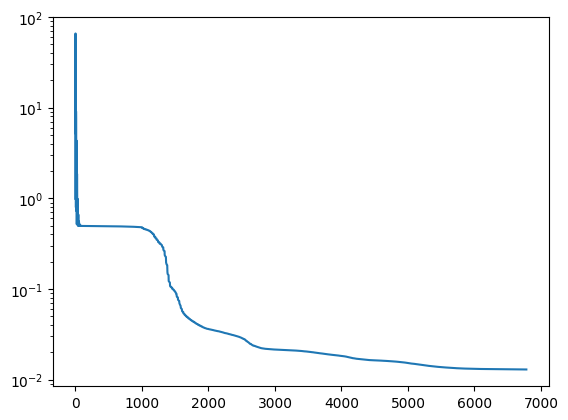

In [6]:
plt.semilogy(loss_hist)

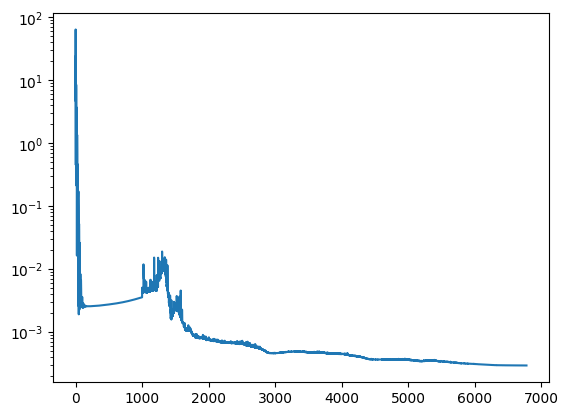

In [7]:
plt.semilogy(loss_res_hist)

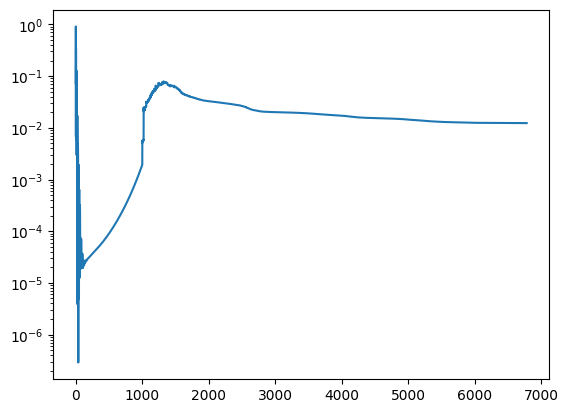

In [8]:
plt.semilogy(loss_bc_hist)

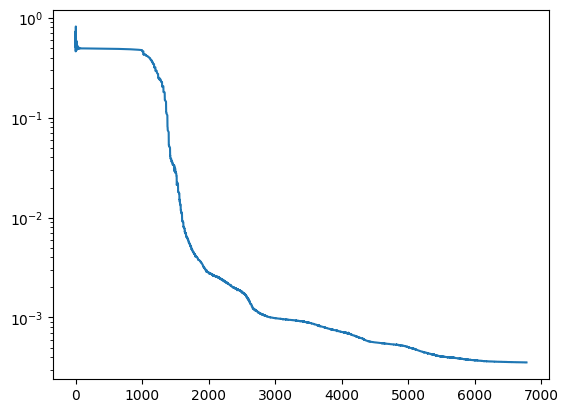

In [9]:
plt.semilogy(loss_ic_hist)

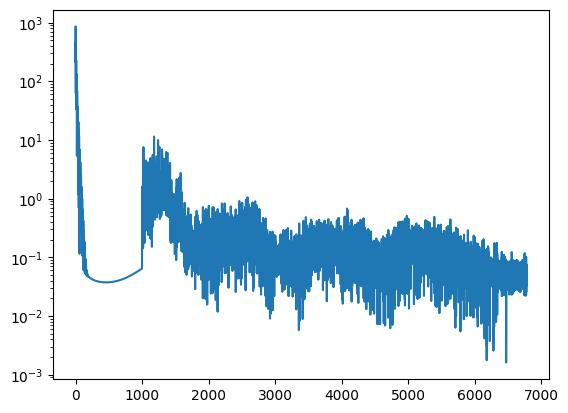

In [10]:
plt.semilogy(grad_norm_hist)

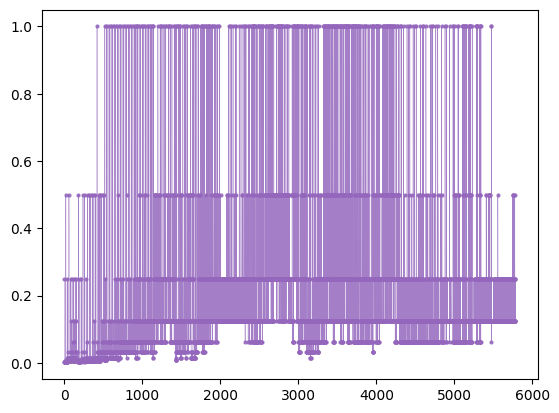

In [11]:
plt.plot([float(i) for i in step_size_hist], label='step size', color='C4',
         alpha=0.85, marker='o', markersize=2, linestyle='solid', linewidth=0.35)